In [1]:
import autograd.numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn.utils.extmath import safe_sparse_dot
from sklearn.datasets import make_classification
from plotting import make_plot
from training_algo import proj_GD,proj_GD_Polyak,NCGD_Polyak
from projection import proj_simplex,proj_simplex_normal

In [2]:
def logsig(x):
    """
    Compute the log-sigmoid function component-wise.
    See http://fa.bianp.net/blog/2019/evaluate_logistic/ for more details.
    """
    out = np.zeros_like(x)
    idx0 = x < -33
    out[idx0] = x[idx0]
    idx1 = (x >= -33) & (x < -18)
    out[idx1] = x[idx1] - np.exp(x[idx1])
    idx2 = (x >= -18) & (x < 37)
    out[idx2] = -np.log1p(np.exp(-x[idx2]))
    idx3 = x >= 37
    out[idx3] = -np.exp(-x[idx3])
    return out

In [3]:
def logistic_loss(x, A, b):
    """Logistic loss, numerically stable implementation.
    
    Parameters
    ----------
    x: array-like, shape (n_features,)
        Coefficients

    A: array-like, shape (n_samples, n_features)
        Data matrix

    b: array-like, shape (n_samples,)
        Labels

    Returns
    -------
    loss: float
    """
    z = np.dot(A, x)
    b = np.asarray(b)
    return np.mean((1-b)*z - logsig(z))

In [4]:
def logistic_gradient(x, A, b_, normalize=True):
    """
    Gradient of the logistic loss at point x with features A, labels b
    If labels are from {-1, 1}, they will be changed to {0, 1} internally
    """
    b = (b_+1) / 2 if -1 in b_ else b_
    activation = scipy.special.expit(safe_sparse_dot(A, x, dense_output=True).ravel())
    grad = A.T.dot(activation - b) #/ x.shape[0]
    grad = np.asarray(grad).ravel()
    if normalize:
        return grad
    return grad * len(b)

In [5]:
#X, y = load_breast_cancer(return_X_y=True)
X, y = make_classification(1000,30)
A = np.array(X)
b = np.array(y)
n,d = A.shape

In [6]:
def oracle(x):
    return logistic_loss(x, A, b), logistic_gradient(x,A,b)

In [7]:
x0 = np.random.rand(d)
x0 = proj_simplex(x0)

In [8]:

res,_,_,x_last = proj_GD(oracle,proj_simplex,proj_simplex_normal,x0,5000)
op_val = np.min(res)
res1,grad1,stepGD,_ = proj_GD_Polyak(oracle,proj_simplex,proj_simplex_normal,x0,1000,op_val)
res2,grad2,stepNC,_ = NCGD_Polyak(oracle,proj_simplex,proj_simplex_normal,x0,1000,op_val)

In [9]:
res1 = res1-op_val
res2 = res2-op_val
labels = ['GD','NCGD']

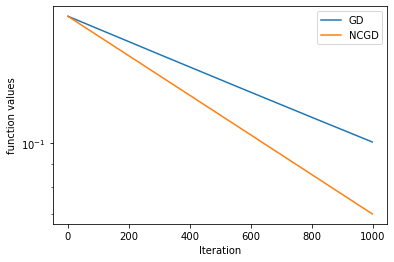

In [10]:
make_plot([res1,res2],labels,'function values')

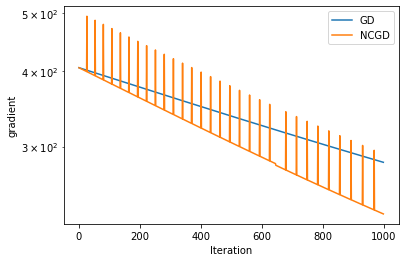

In [11]:
make_plot([grad1,grad2],labels,'gradient')

In [12]:
stepGD_c = np.cumsum(stepGD)
stepNC_c = np.cumsum(stepNC)

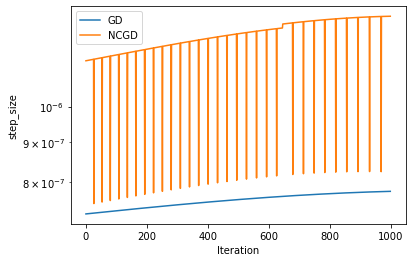

In [13]:
make_plot([stepGD,stepNC],labels,'step_size')

In [14]:
print(stepGD[0])

7.290858469941583e-07
